In [1]:
import os
os.chdir('../')

import shap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='white')

from scipy.stats import pearsonr, spearmanr, zscore
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
data = pd.read_csv('inference_feat.csv')
data['error'] = data['true_ef'] - data['predicted_ef']

data = data.rename(columns={
    'dice_overlap_std': 'dice_similarity_std',
    'dice_overlap_ratio': 'dice_similarity_ratio'
})

df = data[(data['split'] == 'TRAIN') | (data['split'] == 'VAL')]

In [3]:
df.drop(columns=['filename', 'split', 'true_ef', 'predicted_ef'], inplace=True)
X, y = df.drop('error', axis=1), df['error']

/var/folders/z2/x55d_0sd3zl143hy_l05bnpr0000gn/T/ipykernel_75987/3902082103.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['filename', 'split', 'true_ef', 'predicted_ef'], inplace=True)


In [4]:
features = ['volume_ratio', 'length_ratio', 'dice_similarity_std', 'dice_similarity_ratio']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X[features], y, test_size=0.2, random_state=42)

models = [
    ('Random Forest', RandomForestRegressor(n_estimators=100, random_state=1)),
    ('Gradient Boosting', GradientBoostingRegressor(n_estimators=100, random_state=1)),
    ('K-Nearest Neighbors', KNeighborsRegressor())
]

In [6]:
results = []

for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae_value = mean_absolute_error(y_test, y_pred)
    mse_value = mean_squared_error(y_test, y_pred)
    r2_value = r2_score(y_test, y_pred)

    results.append({
        'Model': name,
        'MAE': mae_value,
        'MSE': mse_value,
        'R^2': r2_value
    })

results_df = pd.DataFrame(results)
results_df.sort_values(by='R^2', ascending=False, inplace=True)
results_df

,Model,MAE,MSE,R^2
1,Gradient Boosting,4.442026,42.716484,0.319968
0,Random Forest,4.569772,44.823642,0.286423
2,K-Nearest Neighbors,4.810172,48.522420,0.227540


In [7]:
gb_model = models[1][1]
importances = gb_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

                 Feature  Importance
0           volume_ratio    0.657287
1           length_ratio    0.185610
2    dice_similarity_std    0.079905
3  dice_similarity_ratio    0.077197


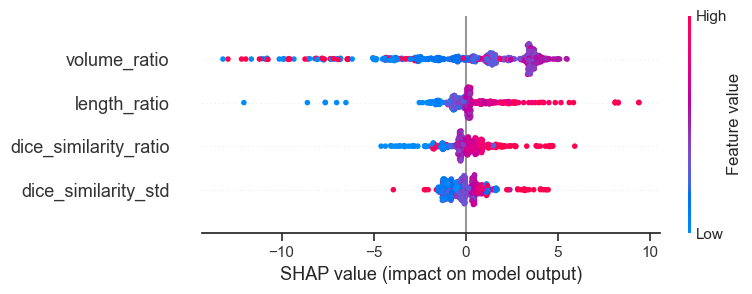

In [8]:
explainer = shap.Explainer(gb_model, X_train)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, feature_names=features)

In [9]:
shap.feature_importance = np.abs(shap_values.values).mean(axis=0)
for feature, importance in zip(features, shap.feature_importance):
    print(f"{feature}: {importance:.4f}")

volume_ratio: 3.0845
length_ratio: 0.9209
dice_similarity_std: 0.7612
dice_similarity_ratio: 0.8262


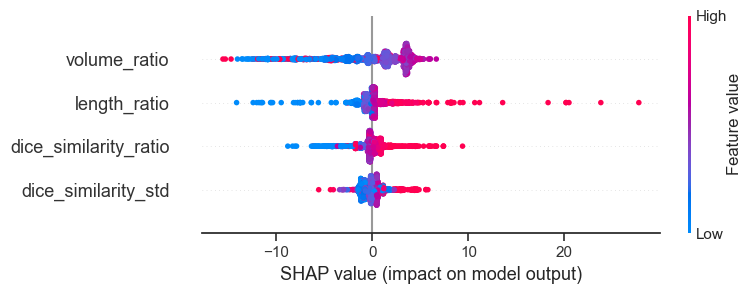

In [10]:
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train, feature_names=features)

In [11]:
shap.feature_importance = np.abs(shap_values.values).mean(axis=0)
for feature, importance in zip(features, shap.feature_importance):
    print(f"{feature}: {importance:.4f}")

volume_ratio: 3.1134
length_ratio: 0.9586
dice_similarity_std: 0.7909
dice_similarity_ratio: 0.8530


volume_ratio: 3.0845
length_ratio: 0.9209
dice_similarity_std: 0.7612
dice_similarity_ratio: 0.8262


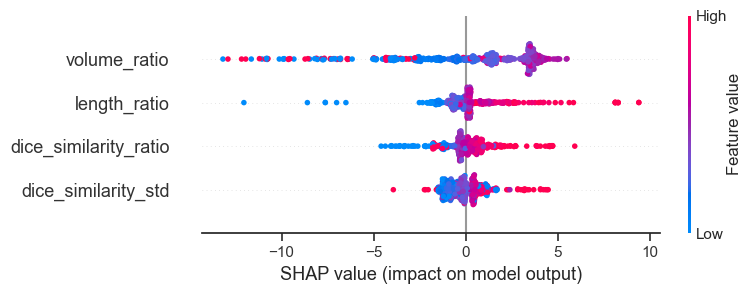

In [12]:
shap_explainer = shap.Explainer(gb_model, X_train)
shap_values_test = shap_explainer(X_test)

global_shap_importance = np.abs(shap_values_test.values).mean(axis=0)
for feature, importance in zip(X_test.columns, global_shap_importance):
    print(f"{feature}: {importance:.4f}")

shap.summary_plot(shap_values_test, X_test, feature_names=X_test.columns)

In [13]:
# Using the best configuration from error analysis notebook 
reg = GradientBoostingRegressor(learning_rate=0.01, max_depth=4, n_estimators=200,
                          random_state=1)

test = data[ data['split'] == 'TEST' ]


In [14]:
X_test = test[features]
y_test = test['error']

In [15]:
reg.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=4, n_estimators=200,
                          random_state=1)

In [16]:
y_pred = reg.predict(X_test)

mae_value = mean_absolute_error(y_test, y_pred)
mse_value = mean_squared_error(y_test, y_pred)
r2_value = r2_score(y_test, y_pred)

print('MAE:', mae_value)
print('MSE:', mse_value)
print('R^2:', r2_value)

MAE: 4.769669957899759
MSE: 41.49683762243192
R^2: 0.34281304924151346


volume_ratio: 2.7756
length_ratio: 0.6049
dice_similarity_std: 0.1616
dice_similarity_ratio: 0.1141


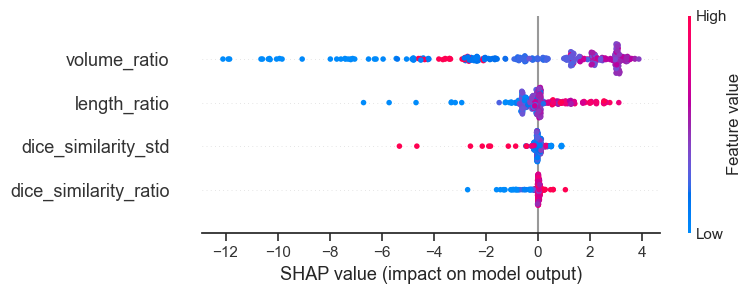

In [17]:
shap_explainer = shap.Explainer(reg, X_train)
shap_values_test = shap_explainer(X_test)

global_shap_importance = np.abs(shap_values_test.values).mean(axis=0)
for feature, importance in zip(X_test.columns, global_shap_importance):
    print(f"{feature}: {importance:.4f}")

shap.summary_plot(shap_values_test, X_test, feature_names=X_test.columns)

- Global shap support dice_ratio but features_importances on Gradient Boosting support dice_std
- Testing both (std is tested on Error Analysis)

In [19]:
features = ['volume_ratio', 'length_ratio', 'dice_similarity_ratio']
reg2 = GradientBoostingRegressor(learning_rate=0.01, max_depth=4, n_estimators=200,
                          random_state=1)
X_train2 = X_train[features]
X_test2 = X_test[features]

reg2.fit(X_train2, y_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=4, n_estimators=200,
                          random_state=1)

In [20]:
y_pred = reg2.predict(X_test2)

mae_value = mean_absolute_error(y_test, y_pred)
mse_value = mean_squared_error(y_test, y_pred)
r2_value = r2_score(y_test, y_pred)

print('MAE:', mae_value)
print('MSE:', mse_value)
print('R^2:', r2_value)

MAE: 4.785995720807174
MSE: 41.738085287496
R^2: 0.33899240105565365


In [21]:
features = ['volume_ratio', 'length_ratio', 'dice_similarity_std']
reg3 = GradientBoostingRegressor(learning_rate=0.01, max_depth=4, n_estimators=200,
                          random_state=1)
X_train3 = X_train[features]
X_test3 = X_test[features]

reg3.fit(X_train3, y_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=4, n_estimators=200,
                          random_state=1)

In [22]:
y_pred = reg3.predict(X_test3)

mae_value = mean_absolute_error(y_test, y_pred)
mse_value = mean_squared_error(y_test, y_pred)
r2_value = r2_score(y_test, y_pred)

print('MAE:', mae_value)
print('MSE:', mse_value)
print('R^2:', r2_value)

MAE: 4.759346753475103
MSE: 41.311137727832026
R^2: 0.3457539853340099


volume_ratio: 2.8934
length_ratio: 0.5185
dice_similarity_std: 0.2032


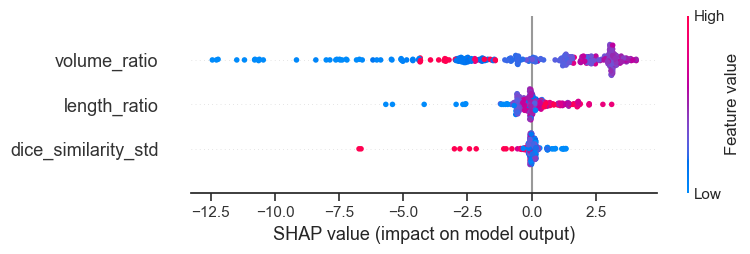

In [23]:
shap_explainer = shap.Explainer(reg3, X_train3)
shap_values_test = shap_explainer(X_test3)

global_shap_importance = np.abs(shap_values_test.values).mean(axis=0)
for feature, importance in zip(X_test3.columns, global_shap_importance):
    print(f"{feature}: {importance:.4f}")

shap.summary_plot(shap_values_test, X_test3, feature_names=X_test3.columns)

In [24]:
features = ['volume_ratio', 'length_ratio']
reg4 = GradientBoostingRegressor(learning_rate=0.01, max_depth=4, n_estimators=200,
                          random_state=1)
X_train4 = X_train[features]
X_test4 = X_test[features]

reg4.fit(X_train4, y_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=4, n_estimators=200,
                          random_state=1)

In [25]:
y_pred = reg4.predict(X_test4)

mae_value = mean_absolute_error(y_test, y_pred)
mse_value = mean_squared_error(y_test, y_pred)
r2_value = r2_score(y_test, y_pred)

print('MAE:', mae_value)
print('MSE:', mse_value)
print('R^2:', r2_value)

MAE: 4.778992516383946
MSE: 41.60433108518363
R^2: 0.3411106712999693
